In [1]:
from SloppyCell.ReactionNetworks import *
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
## load full model and set dynamic vars
model = IO.from_SBML_file('../model/model.xml', id='full_model')
dyn_vars =  ['paurb', 'pmelt_bub1','pmelt_bub1_pp2a', 'pmelt', 'rvsf', 'rvsf_pp1']
nonvars = list(set(model.dynamicVars.keys()) - set(dyn_vars))
for key in nonvars:
    model.set_var_constant(key, is_constant=True)
    model.set_var_optimizable(key, is_optimizable=False)
for var in ['pp1_tot', 'bub1_tot', 'pp2a_tot', 'kln1_tot', 'aurb_tot']:
    model.set_var_optimizable(var, False)

In [32]:
## generate all possible models
## ids are strings of 1/0 indicating presence/absence of reactions
phospho_pars = [
    ['kdp_rvsf_pp1', 'kdp_rvsf_pp2a'],
     ['kp_aurb_bub1','kp_aurb_aurb'],
     ['kdp_aurb_pp1','kdp_aurb_pp2a']]
models = {}
alf = ['01','10','11']
model_iterator = it.product(alf,repeat=3)
for m_i in model_iterator:
    id = ''.join(m_i)
    model_it = model.copy(new_id='model_'+id)
    for i in range(len(m_i)):
        pars = phospho_pars[i]
        for j in range(len(m_i[i])):
            val = float(m_i[i][j])
            model_it.set_var_ic(pars[j], val)
            model_it.set_var_optimizable(pars[j], bool(val))
    models[id] = model_it

In [25]:
model_ic = model.copy(new_id='full_ic')
model_id = 'full_ic'
expt_ic = Experiment('ic')
data_ic = {model_id:{
    'prvsf': {100: (0.1, 0.1),
            1000: (0.1, 0.1),},              
    'pmelt_tot' : {100: (0.1, 0.1),
            1100: (0.1, 0.1),},                              
                             }
                }
expt_ic.set_data(data_ic)
expt_ic.set_fixed_sf({'prvsf': 1, 'pmelt_tot': 1})

In [26]:
model_mps1 = model.copy(new_id='full_mps1')
model_mps1.set_var_constant('mps1', is_constant=False)
model_mps1.add_event(id='mps1_inhibition', trigger='gt(time, 1000)', event_assignments={'mps1': 0})
model_id = 'full_mps1'
expt_mps1 = Experiment('mps1_inhibition')
data_mps1 = {model_id:{
    'prvsf': {100: (1, 0.1),
            1000: (1, 0.1),},              
    'pmelt_tot' : {100: (1, 0.1),
            1100: (0, 0.1),},                              
                             }
                }
expt_mps1.set_data(data_mps1)

In [27]:
model_aurb = model.copy(new_id='full_aurb')
model_aurb.set_var_constant('paurb', is_constant=False)
model_aurb.set_var_constant('aurb_tot', is_constant=False)
model_aurb.add_event(id='aurb_inhibition', trigger='gt(time, 1000)', event_assignments={'paurb': 0, 'aurb_tot': 0})
model_id = 'full_aurb'
expt_aurb = Experiment('aurb_inhibition')
data_aurb = {model_id:{            
    'pmelt_tot' : {100: (1, 0.1),
            1100: (0, 0.01),},                              
                             }
                }
expt_aurb.set_data(data_aurb)

In [28]:
m_ic = Model([expt_ic],[model_ic])
params = KeyedList()
for p,val in model.optimizableVars.items():    
    params.setByKey(p, val.initialValue)
    res = Residuals.PriorInLog(p+'_prior', p, log(val.initialValue), log(sqrt(100)))    
    m_ic.AddResidual(res)

In [29]:
params_ic_opt = Optimization.fmin_lm_log_params(m_ic, params, maxiter=200, disp=False)

In [32]:
model_ic_c = model.copy(new_id='model_ic_c')
model_ic_c.add_constraint(id='rvsf03', trigger='lt(time, 100.0) or lt(prvsf, 0.3)')
model_ic_c.add_constraint(id='melt03', trigger='lt(time, 100.0) or lt(pmelt_tot, 0.3)')
model_id = 'model_ic_c'
expt_ic_c = Experiment('fit_ic_c')
data_ic_c = {model_id:{
    'prvsf': {100: (0.1, 1000),
            1100: (0.1, 1000),},              
    'pmelt_tot' : {100: (0.1, 1000),
            1100: (0.1, 1000),},                              
                             }
                }
expt_ic_c.set_data(data_ic_c)
expt_ic_c.set_fixed_sf({'prvsf': 1, 'pmelt_tot': 1})

In [38]:
m = Model([expt_ic_c, expt_aurb, expt_mps1],[model_ic_c, model_aurb, model_mps1])
params = KeyedList()
for p,val in model.optimizableVars.items():    
    params.setByKey(p, val.initialValue)
    res = Residuals.PriorInLog(p+'_prior', p, log(val.initialValue), log(sqrt(100)))    
    m.AddResidual(res)

In [39]:
params_opt = Optimization.fmin_lm_log_params(m, params_ic_opt, maxiter=200, disp=True)

Iteration number 0
Current cost 100.78906714
Move 1 gives cost of 100.46860967
Move 2 gives cost of  inf


Iteration number 1
Current cost 100.46860967
Move 1 gives cost of 100.227918519
Move 2 gives cost of  inf


Iteration number 2
Current cost 100.227918519
Move 1 gives cost of inf
Move 2 gives cost of  inf


Iteration number 3
Current cost 100.20717595
Move 1 gives cost of 100.187042677
Move 2 gives cost of  inf


Iteration number 4
Current cost 100.187042677
Move 1 gives cost of 100.167495103
Move 2 gives cost of  inf


Iteration number 5
Current cost 100.167495103
Move 1 gives cost of 100.148509851
Move 2 gives cost of  inf


Iteration number 6
Current cost 100.148509851
Move 1 gives cost of inf
Move 2 gives cost of  inf


Iteration number 7
Current cost 100.148322222
Move 1 gives cost of 100.148134646
Move 2 gives cost of  inf


Iteration number 8
Current cost 100.148134646
Move 1 gives cost of 100.147947125
Move 2 gives cost of  inf


Iteration number 9
Current cost 100.147947125
Move 1 gives cost of inf
Move 2 gives cost of  inf


Iteration number 10
Current cost 100.147928375
Move 1 gives cost of 100.147909626
Move 2 gives cost of  inf


Iteration number 11
Current cost 100.147909626
Move 1 gives cost of 100.147890877
Move 2 gives cost of  inf


Iteration number 12
Current cost 100.147890877
Move 1 gives cost of 100.147872129
Move 2 gives cost of  inf


Iteration number 13
Current cost 100.147872129
Move 1 gives cost of 100.147853382
Move 2 gives cost of  inf


Iteration number 14
Current cost 100.147853382
Move 1 gives cost of 100.147834635
Move 2 gives cost of  inf


Iteration number 15
Current cost 100.147834635
Move 1 gives cost of 100.147815888
Move 2 gives cost of  inf


Iteration number 16
Current cost 100.147815888
Move 1 gives cost of inf
Move 2 gives cost of  inf


Iteration number 17
Current cost 100.147814013
Move 1 gives cost of 100.147812139
Move 2 gives cost of  inf


Iteration number 18
Current cost 100.147812139
Move 1 gives cost of 100.147810264
Move 2 gives cost of  inf


Iteration number 19
Current cost 100.147810264
Move 1 gives cost of 100.14780839
Move 2 gives cost of  inf


Iteration number 20
Current cost 100.14780839
Move 1 gives cost of 100.147806515
Move 2 gives cost of  inf


Iteration number 21
Current cost 100.147806515
Move 1 gives cost of 100.14780464
Move 2 gives cost of  inf


Iteration number 22
Current cost 100.14780464
Move 1 gives cost of 100.147802766
Move 2 gives cost of  inf


Iteration number 23
Current cost 100.147802766
Move 1 gives cost of 100.147800891
Move 2 gives cost of  inf


Iteration number 24
Current cost 100.147800891
Move 1 gives cost of 100.147799017
Move 2 gives cost of  inf


Iteration number 25
Current cost 100.147799017
Move 1 gives cost of inf
Move 2 gives cost of  inf


Iteration number 26
Current cost 100.147798829
Move 1 gives cost of 100.147798642
Move 2 gives cost of  inf


Iteration number 27
Current cost 100.147798642
Move 1 gives cost of 100.147798454
Move 2 gives cost of  inf


Iteration number 28
Current cost 100.147798454
Move 1 gives cost of 100.147798267
Move 2 gives cost of  inf


Iteration number 29
Current cost 100.147798267
Move 1 gives cost of 100.147798079
Move 2 gives cost of  inf


Iteration number 30
Current cost 100.147798079
Move 1 gives cost of 100.147797892
Move 2 gives cost of  inf


Iteration number 31
Current cost 100.147797892
Move 1 gives cost of 100.147797704
Move 2 gives cost of  inf


Iteration number 32
Current cost 100.147797704
Move 1 gives cost of 100.147797517
Move 2 gives cost of  inf


Iteration number 33
Current cost 100.147797517
Move 1 gives cost of inf
Move 2 gives cost of  inf


Iteration number 34
Current cost 100.147797498
Move 1 gives cost of 100.14779748
Move 2 gives cost of  inf


Iteration number 35
Current cost 100.14779748
Move 1 gives cost of 100.147797461
Move 2 gives cost of  inf


Iteration number 36
Current cost 100.147797461
Move 1 gives cost of 100.147797442
Move 2 gives cost of  inf


Iteration number 37
Current cost 100.147797442
Move 1 gives cost of inf
Move 2 gives cost of  inf


Iteration number 38
Current cost 100.14779744
Move 1 gives cost of 100.147797438
Move 2 gives cost of  inf


Iteration number 39
Current cost 100.147797438
Move 1 gives cost of 100.147797436
Move 2 gives cost of  inf


Iteration number 40
Current cost 100.147797436
Move 1 gives cost of 100.147797435
Move 2 gives cost of  inf


Iteration number 41
Current cost 100.147797435
Move 1 gives cost of inf
Move 2 gives cost of  inf


Iteration number 42
Current cost 100.147797434
Move 1 gives cost of 100.147797434
Move 2 gives cost of  inf


Iteration number 43
Current cost 100.147797434
Move 1 gives cost of 100.147797434
Move 2 gives cost of  inf


Iteration number 44
Current cost 100.147797434
Move 1 gives cost of 100.147797434
Move 2 gives cost of  inf


Iteration number 45
Current cost 100.147797434
Move 1 gives cost of 100.147797434
Move 2 gives cost of  inf


Iteration number 46
Current cost 100.147797434
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 47
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 48
Current cost 100.147797433
Move 1 gives cost of inf
Move 2 gives cost of  inf


Iteration number 49
Current cost 100.147797433
Move 1 gives cost of inf
Move 2 gives cost of  inf


Iteration number 50
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 51
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 52
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 53
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 54
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 55
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 56
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 57
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 58
Current cost 100.147797433
Move 1 gives cost of inf
Move 2 gives cost of  inf


Iteration number 59
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 60
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 61
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 62
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 63
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 64
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 65
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 66
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 67
Current cost 100.147797433
Move 1 gives cost of inf
Move 2 gives cost of  inf


Iteration number 68
Current cost 100.147797433
Move 1 gives cost of inf
Move 2 gives cost of  inf


Iteration number 69
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 70
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 71
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 72
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 73
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 74
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 75
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 76
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf
Iteration number 77
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  100.147797433


Iteration number 78
Current cost 100.147797433
Move 1 gives cost of inf
Move 2 gives cost of  inf


Iteration number 79
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 80
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 81
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 82
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 83
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 84
Current cost 100.147797433
Move 1 gives cost of inf
Move 2 gives cost of  inf


Iteration number 85
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 86
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 87
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 88
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 89
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 90
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 91
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 92
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 93
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 94
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 95
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 96
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 97
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 98
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 99
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 100
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 101
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 102
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 103
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 104
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 105
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 106
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 107
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 108
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 109
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 110
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 111
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 112
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 113
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 114
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 115
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 116
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 117
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 118
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 119
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 120
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 121
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 122
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 123
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 124
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 125
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 126
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 127
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 128
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 129
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 130
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 131
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 132
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 133
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 134
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 135
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 136
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 137
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 138
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 139
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 140
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 141
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 142
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 143
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 144
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 145
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 146
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 147
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 148
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 149
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 150
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 151
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 152
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 153
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 154
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 155
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 156
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 157
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 158
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 159
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 160
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 161
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 162
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 163
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 164
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 165
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 166
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 167
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 168
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 169
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 170
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 171
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 172
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 173
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 174
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 175
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 176
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 177
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 178
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 179
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 180
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 181
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 182
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 183
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 184
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 185
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 186
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 187
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 188
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 189
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 190
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 191
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 192
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 193
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 194
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 195
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 196
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 197
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 198
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf


Iteration number 199
Current cost 100.147797433
Move 1 gives cost of 100.147797433
Move 2 gives cost of  inf
 Current function value: 100.147797
 Iterations: 200
 Function evaluations: 618
 Gradient evaluations: 201
 Maximum number of iterations exceeded with no convergence 


In [44]:
traj = model_ic_c.integrate(np.linspace(0,1100,101), params_ic_opt)
traj_c = model_ic.integrate([0,1100], params_opt)
traj_mps1 = model_mps1.integrate([0,1100], params_opt)
traj_aurb = model_aurb.integrate([0,1100], params_opt)

(990, 1100)

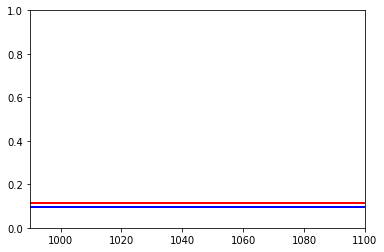

In [45]:
plt.plot(traj.timepoints, traj.get_var_traj('prvsf'), 'b-')
plt.plot(traj.timepoints, traj.get_var_traj('pmelt_tot'), 'r-')
#plt.plot(traj_c.timepoints, traj_c.get_var_traj('prvsf'), 'b--')
#plt.plot(traj_c.timepoints, traj_c.get_var_traj('pmelt_tot'), 'r--')
#plt.plot(traj_mps1.timepoints, traj_mps1.get_var_traj('prvsf'), 'b--')
#plt.plot(traj_mps1.timepoints, traj_mps1.get_var_traj('pmelt_tot'), 'r--')
#plt.plot(traj_aurb.timepoints, traj_aurb.get_var_traj('prvsf'), 'b:')
#plt.plot(traj_aurb.timepoints, traj_aurb.get_var_traj('pmelt_tot'), 'r:')
plt.ylim([0,1])
plt.xlim([990,1100])